In [1]:
#This is the code that we have written (in progress) to solve Homework 1 of the FRIB Theory TALENT Summer School
#This code will (when we complete it) compute scattering cross sections as a function of E and l via the partial-wave method, using the Numerov integration method to compute the scattering wavefunction

#Outputs are consistent with FRESCO to within ~10% for l = 0,1.  Discrepancies (likely related to matching) are noted at higher values of l.

#Authors:  Chad Ummel and Rajesh Ghimire

import math
import matplotlib.pyplot as plt
import numpy as np
from scipy import special as sp
from scipy import integrate as integ

In [2]:
#Physical constants
hbar = 197.3286 #(hbar*c in MeV fm)
mp = 938.272 #Proton mass (in MeV)
mn = 939.565 #Neutron mass (in MeV)
mu = mp*mn/(mp+mn) #Reduced mass

In [3]:
#Subroutine to define the potential and k
def potential(E,l,r0,h,nmax):

    ECM = mn/(mp+mn)*E #CM Energy (assuming proton beam)
    
    #Malfliet-Tjon potential parameters
    VA = 626.8932
    muA = 1.550
    VR = 1438.7228
    muR = 3.11

    #Construct the effective potential and k
    n = np.linspace(0,nmax,nmax+1)
    r = r0+n*h
    #V = np.zeros(nmax+1) #for debugging
    V = VR*np.exp(-muR*r)/r - VA*np.exp(-muA*r)/r
    Vang = l*(l+1)*(hbar**2)/(2*mu*(r**2))
    Veff = V + Vang
    ksq = 2*mu*(ECM - Veff)/(hbar**2)
    k = np.sqrt(ksq)
    
    return(r,ECM,V,Veff,k,ksq)

In [4]:
#Numerov method subroutine to compute the wavefunction
def numerov(E,l):
    
    #Numerical Integration parameters
    h = 0.05 #Step size in fm
    
    #Set starting point, r_0
    if l==0:
        r0 = 1e-8
    else:
        r0 = 2.0*l*h #Starting point for r (in fm).
        
    rmax = 20*(l+1) #*math.sqrt(E) #maximum r in fm
    
    nmax = int(round((rmax-r0)/h)) #number of steps

    (r,ECM,V,Veff,k,ksq) = potential(E,l,r0,h,nmax)
    
    #Define u and set Boundary conditions
    u = [0]*(nmax+1)
    u[0] = 0 #u(r=0) = 0
    u[1] = h**(l+1) #What is a good choice for this?
    u[2] = 2*u[1]-h**2*ksq[1]*u[1]

    #Compute the wavefunction using the Numerov method
    for i in range(2,nmax,1):
        u[i+1] = (2*(1-5/12*h**2*ksq[i])*u[i]-(1+1/12*h**2*ksq[i-1])*u[i-1])/(1+1/12*h**2*ksq[i+1])
        
    return(r0,h,nmax,r,ECM,Veff,k,u)

In [5]:
#Compute the phase shift using Carl's pseudo-Wronskian method
def phaseshift(E,l):
    (r0,h,nmax,r,ECM,Veff,k,u)=numerov(E,l)
    deltal = np.arctan((u[-2]*k[-1]*r[-1]*sp.spherical_jn(l,k[-1]*r[-1])-u[-1]*k[-2]*r[-2]*sp.spherical_jn(l,k[-2]*r[-2]))/(u[-2]*k[-1]*r[-1]*sp.spherical_yn(l,k[-1]*r[-1])-u[-1]*k[-2]*r[-2]*sp.spherical_yn(l,k[-2]*r[-2])))
    return(r,ECM,Veff,k,u,deltal)

In [6]:
#Compute the angular distribution from the phaseshift
#FRESCO indicates we're off by some constant factor in this subroutine
def amp(E,lmax):
    theta=np.linspace(0,math.pi,181)
    deltal=np.zeros(lmax+1)
    fre=[[]*len(theta)]*(lmax+1) #np.zeros(len(theta))
    fim=[[]*len(theta)]*(lmax+1) #np.zeros(len(theta))
    fretot = np.zeros(len(theta))
    fimtot = np.zeros(len(theta))
    ang=[[]*len(theta)]*(lmax+1)
    cs_partial = 0
    for l in range(0,lmax+1,1):
        (r,ECM,Veff,k,u,deltal[l])=phaseshift(E,l)
        knorm = math.sqrt(2*mu*ECM)/hbar
        Pl=sp.legendre(l)
        fre[l]=1/knorm*(2*l+1)*math.cos(deltal[l])*math.sin(deltal[l])*Pl(np.cos(theta))
        fim[l]=1/knorm*(2*l+1)*(math.sin(deltal[l]))**2*Pl(np.cos(theta))
        fretot = fretot+fre[l]
        fimtot = fimtot+fim[l]
        cs_partial = cs_partial+4*math.pi/(knorm**2)*(2*l+1)*((math.sin(deltal[l]))**2)*10
    cs_im = 4*math.pi/knorm*fimtot[0]*10
    ang=(fretot**2+fimtot**2)*10 #Convert from fm^-2 to mb
    return(theta,fretot,fimtot,ang,cs_partial,cs_im)

In [7]:
#Get the total, integrated cross section using a trapezoidal integral
def cstot(E,lmax):
    (theta,fretot,fimtot,ang,cs_partial,cs_im)=amp(E,lmax)
    cs_int=0
    for i in range(0,len(theta)-1,1):
        cs_int=cs_int+2*math.pi*(ang[i+1]*math.sin(theta[i+1])+ang[i]*math.sin(theta[i]))/2*(theta[i+1]-theta[i])
    return(cs_partial,cs_im,cs_int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in sqrt


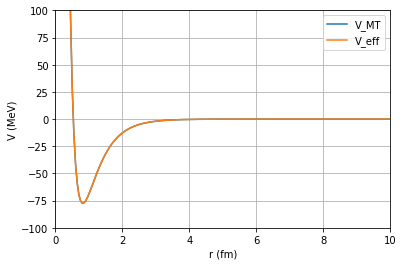

In [8]:
#Debugging cell to check V_MT and V_eff plots
E=2.5*(mp+mn)/mn
l=0

#Numerical Integration parameters
h = 0.05 #Step size in fm

#Set starting point, r_0
if l==0:
    r0 = 1e-6
else:
    r0 = 2.0*l*h #Starting point for r (in fm).

rmax = 20*(l+1) #*math.sqrt(E) #maximum r in fm
    
nmax = int(round((rmax-r0)/h)) #number of steps

(r,ECM,V,Veff,k,ksq) = potential(E,l,r0,h,nmax)
plt.grid(1)
plt.plot(r,V,label="V_MT")
plt.plot(r,Veff,label="V_eff")
plt.ylim(-100,100)
plt.xlim(0,10)
plt.xlabel('r (fm)')
plt.ylabel('V (MeV)')
plt.legend();

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in sqrt


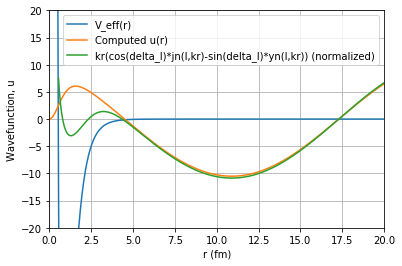

In [9]:
#Debugging cell to check plot of wavefunction against asymptotic behavior
E=2.5*(mp+mn)/mn
l=0
(r,ECM,Veff,k,u,deltal) = phaseshift(E,l)
asymptotic=k*r*(math.cos(deltal)*sp.spherical_jn(l,k*r)-math.sin(deltal)*sp.spherical_yn(l,k*r))
ANC = u[-1]/asymptotic[-3]
plt.plot(r,Veff,label="V_eff(r)")
plt.plot(r,u,label="Computed u(r)")
plt.plot(r,ANC*asymptotic,label="kr(cos(delta_l)*jn(l,kr)-sin(delta_l)*yn(l,kr)) (normalized)")
plt.xlim(0,r[-1])
plt.ylim(-20,20)
plt.grid(1)
plt.xlabel('r (fm)')
plt.ylabel('Wavefunction, u');
plt.legend();

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in sqrt


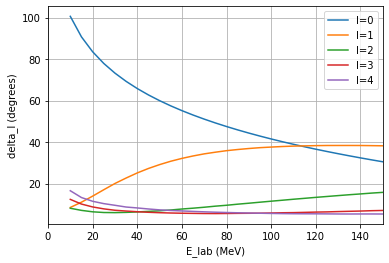

In [10]:
#Loop to plot the phase shift as a function of E and l
#Note that the  E<5 MeV behavior of the phase shifts is unphysical
E = np.linspace(10,150,int((150-10)/5+1))
deltal = np.zeros(len(E))
for l in range(0,5,1):
    for i in range(len(E)-1,-1,-1):
        (r,ECM,Veff,k,u,deltal[i])=phaseshift(E[i],l)
        if i<len(E)-1:
            if np.abs(deltal[i+1]-deltal[i])>(math.pi)/2:  #Get rid of jumps in delta across pi/2
                deltal[i] = deltal[i]+np.sign(deltal[i+1])*math.pi
    plt.plot(E,deltal/math.pi*180,label="l=%s" %l)
plt.grid()
plt.xlabel("E_lab (MeV)")
plt.ylabel("delta_l (degrees)")
plt.xlim(0,E[-1])
plt.legend();

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in sqrt


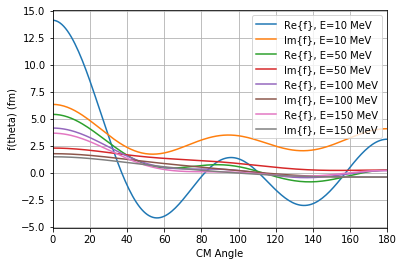

In [11]:
#Debugging cell to check scattering amplitude plots
E=10
lmax=4
(theta,fretot,fimtot,ang,cs_partial,cs_im)=amp(E,lmax)
plt.plot(theta*180/math.pi,fretot,label="Re{f}, E=10 MeV")
plt.plot(theta*180/math.pi,fimtot,label="Im{f}, E=10 MeV")
E=50
(theta,fretot,fimtot,ang,cs_partial,cs_im)=amp(E,lmax)
plt.plot(theta*180/math.pi,fretot,label="Re{f}, E=50 MeV")
plt.plot(theta*180/math.pi,fimtot,label="Im{f}, E=50 MeV")
E=100
(theta,fretot,fimtot,ang,cs_partial,cs_im)=amp(E,lmax)
plt.plot(theta*180/math.pi,fretot,label="Re{f}, E=100 MeV")
plt.plot(theta*180/math.pi,fimtot,label="Im{f}, E=100 MeV")
E=150
(theta,fretot,fimtot,ang,cs_partial,cs_im)=amp(E,lmax)
plt.plot(theta*180/math.pi,fretot,label="Re{f}, E=150 MeV")
plt.plot(theta*180/math.pi,fimtot,label="Im{f}, E=150 MeV")
plt.grid()
plt.xlim(0,180)
plt.xlabel("CM Angle")
plt.ylabel("f(theta) (fm)")
plt.legend();

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in sqrt
No handles with labels found to put in legend.


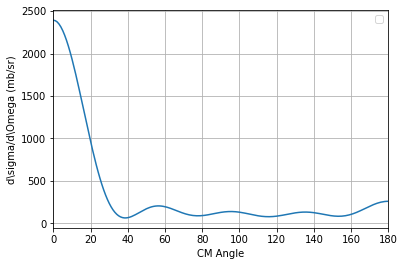

In [12]:
#Debugging cell to check angular distribution plot
E=10.0
lmax=4
(theta,fre,fim,ang,cs_partial,cs_im)=amp(E,lmax)
plt.plot(theta/math.pi*180,ang)
plt.grid()
plt.xlim(0,180)
plt.xlabel("CM Angle")
plt.ylabel("d\sigma/d\Omega (mb/sr)")
plt.legend();

In [13]:
#Debugging cell to check total integrated cross section in mb
E=100.0
lmax=0
(cs_partial,cs_im,cs_int)=cstot(E,lmax)
print("The total cross section, computed directly by adding partial waves, is %s mb" %cs_partial)
print("The total cross section, computed from Im{f(theta=0)} is %s mb" %cs_im)
print("The total cross section, computed by integrating the differential cross section, is %s mb" %cs_int)

The total cross section, computed directly by adding partial waves, is 45.826810721570126 mb
The total cross section, computed from Im{f(theta=0)} is 45.826810721570126 mb
The total cross section, computed by integrating the differential cross section, is 45.82564741192749 mb


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in sqrt


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in sqrt


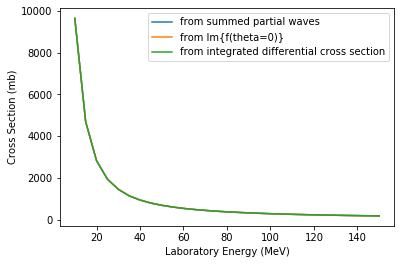

In [14]:
#Plot the total cross section vs. energy
lmax=7 #Note that convergence is not observed for lmax<7
E = np.linspace(10,150,int((150-10)/5+1))
cs_partial = np.zeros(len(E))
cs_im = np.zeros(len(E))
cs_int = np.zeros(len(E))
for i in range(0,len(E),1):
    (cs_partial[i],cs_im[i],cs_int[i])=cstot(E[i],lmax)
plt.plot(E,cs_partial,label="from summed partial waves")
plt.plot(E,cs_im,label="from Im{f(theta=0)}")
plt.plot(E,cs_int,label="from integrated differential cross section")
plt.xlabel("Laboratory Energy (MeV)")
plt.ylabel("Cross Section (mb)")
plt.legend();